The prototype is based upon this research paper
https://label.ag/fruit-counting-iros18-inreview.pdf titled 

Robust Fruit Counting: Combining Deep Learning, Tracking, and Structure
from Motion


The actual model described in the paper:

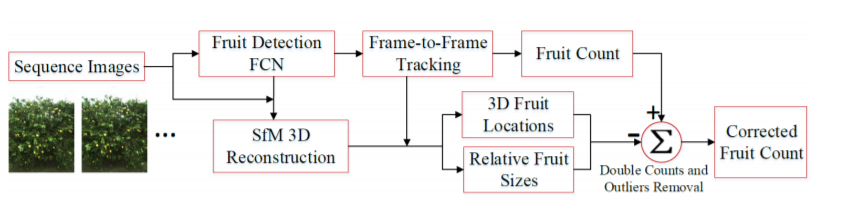

In [5]:
from IPython.display import Image
Image(filename='actual model.PNG')

The model I have implemented so far, however I have used a very basic haar cascade model that detects faces. I would be switching it out, as it face identification per frame isn't so good. It easily looses track. With that in mind the model performs reasonably. 

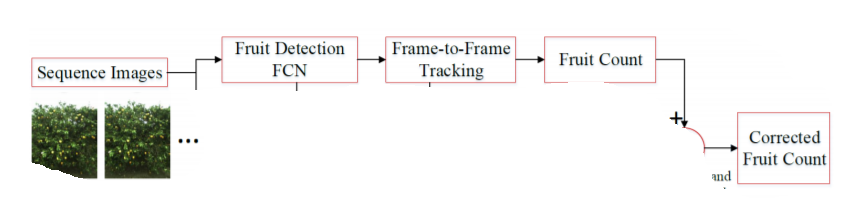

In [6]:
from IPython.display import Image
Image(filename='implemented model.PNG')

In [1]:
import logging
LOG_FILENAME = 'track.log'
logging.basicConfig(filename=LOG_FILENAME,level=logging.DEBUG,filemode='w')

In [2]:
import numpy as np

In [84]:
class Entity():
    
    import cv2 as cv
    import math
    import numpy as np
    
    feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 1,
                       blockSize = 2 )
    
    crop = lambda x,y,w,h,frame:frame[y:y+h,x:x+w] 

  
    
    def __init__(self,ob,frame):
        
        self.frame_count = 0
        
        (x,y,w,h) = ob
        
        self.width = w
        
        self.height = h
        
        self.orgin = np.array([x,y]) 
        
        self.area = self.width*self.height
        
        cropped_frame = self.crop(frame)
        
        self.frames = []
        
        self.frames.append(cropped_frame)
        
        self.reps = self.getFeatures(cropped_frame)
        
        # iterate through all features, and update with respect to origin
        try:
            for i in range(self.reps.shape[0]):
                self.reps[i] = self.reps[i] + self.orgin
            self.current = self.reps[0] 
        except Exception:
            self.current = None      
        
         
    
    def getFeatures(self,frame): 
        
        return cv.goodFeaturesToTrack(frame, mask = None, **self.feature_params)
    
    
    def crop(self,frame):
        
        x,y = self.orgin.tolist()
        
        cropped = frame[y:y+self.height,x:x+self.width]
   
        return cropped


    def update(self,u):
        
        offset = u - self.current
        
        import random 
        self.current = u[random.randint(0,u.shape[0]-1)]
        
        #logging.info("\t\tupdating enity rep as: {}".format(u))
    
        #self.moved_ref = self.orgin + offset
        
        #logging.info("\t\tapproximating entity orgin change as {}".format(self.moved_ref))
    

    def cost(self,other):
         
           
        distance =  np.linalg.norm( self.current- other.current)**2/(self.area + other.area) + 1
        
        #logging.info("\t\tinitial anticipated distance {}".format(distance))
        
        """cnt_s = np.array([self.moved_ref.ravel()[0],self.moved_ref.ravel()[1],self.moved_ref.ravel()[0]+self.width,self.moved_ref.ravel()[1]
                          ,self.moved_ref.ravel()[0]+self.width,self.moved_ref.ravel()[1] + self.height, 
                          self.moved_ref.ravel()[0],self.moved_ref.ravel()[1]+self.height]) 
        
        
        
        cnt_s = cnt_s.reshape(4,1,2)
        
        cnt_o = np.array([other.orgin.ravel()[0],other.orgin.ravel()[1],other.orgin.ravel()[0]+self.width,other.orgin.ravel()[1]
                          ,other.orgin.ravel()[0]+other.width,other.orgin.ravel()[1] + other.height, 
                          other.orgin.ravel()[0],other.orgin.ravel()[1]+other.height]) 
        
 
        cnt_o = cnt_o.reshape(4,1,2)
        
        #logging.info("\t\tcountour of the entity {}".format(cnt_s))
        
        #logging.info("\t\tcountour of the entity measured {}".format(cnt_o))
        
        cnt = np.vstack((cnt_s,cnt_o)).astype(int)
        
        #logging.info("\t\tcountour of the merged entities {}".format(cnt))
        
        hull =  cv.convexHull(cnt,returnPoints= False)
        
        defects = cv.convexityDefects(cnt,hull)
        
        
        de = []
        
        for i in range(defects.shape[0]): 
            s,e,f,d = defects[i,0]      
            de.append(tuple(cnt[f][0]))
            
        #logging.info("\t\tpoints that probably lay in each other contours {}".format(de))
            
        if len(defects) == 2:
             if(cv.pointPolygonTest(cnt_o,de[0],False) <= 0 and cv.pointPolygonTest(cnt_s,de[0],False) <= 0 ):
                    distance = distance - abs((de[0][1] - de[1][1])*(de[0][0] - de[1][0]))/(self.area + other.area)
        """           
        return distance
  
 

In [85]:
class EntityTracker():
    

    import cv2 as cv
    import numpy as np
    from munkres import Munkres, print_matrix
    
    face_cascade = cv.CascadeClassifier('opencv/data/haarcascades/haarcascade_frontalface_alt.xml')
    
    gray = lambda self,frame: cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    objects = lambda self,frame: self.face_cascade.detectMultiScale(frame)
    
    
    lk_params = dict( winSize  = (2,2),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
    
    
    
    def __init__(self,_init_frame):
        
        logging.info('\n---------------------- initiating new tracking -----------------------------------------------------\n')
        
        self.prev_frame = _init_frame
        self.entities = self.getEntities(self.gray(self.prev_frame))
        logging.info('\tenitities created!!')
  
        
    def getEntities(self,frame):
        
        entities = []
        
        data =  self.objects(frame)
        
        for ob in data: 
            
            logging.info('creating entity!!')
            entity = Entity(ob,frame)
            
            if entity.current is not None:
                entities.append(entity)
            else:
                logging.info('enitity not tracked!!')
      
        return entities
    
    def updateExistingEntities(self,frame):
        
        logging.info('new frame is used update the entities!')
        
        lk_params = dict( winSize  = (3,3),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
        
        
        # code for previous logic
        
        buffer = []
        
        for entity in self.entities:
            
            updated_reps_object, st, err = cv.calcOpticalFlowPyrLK(self.prev_frame, frame, entity.reps  , None,**lk_params)
            
            index =  np.where(err == np.amin(err))
            
            logging.debug("good rep points {}".format(updated_reps_object[index]))
        
            entity.update(updated_reps_object[index]) 
            
   
    def getCostMatrix(self,unverified_entities):
        
        row = []
        matrix = []
        
        for unverified_entity in unverified_entities:
            row = []
            for entity in self.entities:
                row.append(entity.cost(unverified_entity))
            matrix.append(row)
            
        logging.info("matrix generated {}".format(matrix))
        
        return matrix
           
    
    def discover_entities(self,nextFrame):
        
        logging.info("number of verified entities object are set {}".format(len(self.entities)))
        
        self.next_frame = nextFrame
        
        self.updateExistingEntities(self.next_frame)
        
        unverified_entities = self.getEntities(self.gray(self.next_frame))
        
        self.unverified_entities = unverified_entities
        
        logging.info("number of unverified entities object are set {}".format(len(unverified_entities)))
        
        matrix = self.getCostMatrix(unverified_entities)
        
        from munkres import Munkres, print_matrix
        
        m = Munkres()
        
        indices = m.compute(matrix)
        
        logging.info("matches made with entities and unverified_entities {}".format(indices))
        
        indices_ = { x:y for x,y in indices}
        
        # go through every key 0 - n-1, where n is no of unverified enitities , if in dictionory  then tranfer the unverified enitity parameters and update the count,
        #  parameters to existing enitiy else create new enitity
        
        new_entities = []
        
        for k in range(len(unverified_entities)):
            
            if k in indices_:
                
                self.entities[indices_[k]].orgin = unverified_entities[k].orgin
                self.entities[indices_[k]].width = unverified_entities[k].width
                self.entities[indices_[k]].height = unverified_entities[k].height
                self.entities[indices_[k]].frames.append(unverified_entities[k].frames[0])
                self.entities[indices_[k]].current = unverified_entities[k].current
                self.entities[indices_[k]].frame_count = self.entities[indices_[k]].frame_count + 1
            else:
                new_entities.append(unverified_entities[k])
        
        logging.debug("newly identified entities {}".format(new_entities)) 
        self.entities.extend(new_entities) 
        self.prev_frame = nextFrame
    
        

The entity identification is done from frame as well as the corresponding tracking.

In [7]:
# set up auxullary function
import cv2 as cv
cap = cv.VideoCapture('Pexels Videos 2851.mp4')

In [8]:
ret, old_frame = cap.read()  

In [86]:
et = EntityTracker(old_frame)

In [10]:
ret, new_frame_ = cap.read()  

In [82]:
et.discover_entities(new_frame_)

In [35]:
et.entities[1].current

array([[317., 536.]], dtype=float32)

In [ ]:
ret, new_frame = cap.read()

In [ ]:
et.discover_entities(new_frame)

In [ ]:
ret, new_frame_2 = cap.read()

In [ ]:
et.discover_entities(new_frame_2)

I didn't track all the frames, since the program took to long. So I ran for limited frames.

In [87]:
i = 0

while(cap.isOpened()):
    
    ret, new_frame = cap.read()
    print(new_frame.shape,i)
    et.discover_entities(new_frame)
    if new_frame is None:  
        break
    i=i+1
    

(1080, 1920, 3) 0
(1080, 1920, 3) 1
(1080, 1920, 3) 2
(1080, 1920, 3) 3
(1080, 1920, 3) 4
(1080, 1920, 3) 5
(1080, 1920, 3) 6
(1080, 1920, 3) 7
(1080, 1920, 3) 8
(1080, 1920, 3) 9
(1080, 1920, 3) 10
(1080, 1920, 3) 11
(1080, 1920, 3) 12
(1080, 1920, 3) 13
(1080, 1920, 3) 14
(1080, 1920, 3) 15
(1080, 1920, 3) 16
(1080, 1920, 3) 17
(1080, 1920, 3) 18
(1080, 1920, 3) 19
(1080, 1920, 3) 20
(1080, 1920, 3) 21
(1080, 1920, 3) 22
(1080, 1920, 3) 23
(1080, 1920, 3) 24
(1080, 1920, 3) 25
(1080, 1920, 3) 26
(1080, 1920, 3) 27
(1080, 1920, 3) 28
(1080, 1920, 3) 29
(1080, 1920, 3) 30
(1080, 1920, 3) 31
(1080, 1920, 3) 32
(1080, 1920, 3) 33
(1080, 1920, 3) 34
(1080, 1920, 3) 35
(1080, 1920, 3) 36


KeyboardInterrupt: 

I have tracked the and saved the images to get an visual idea how its performing, below 1st enity has zero frames

In [12]:
len(et.entities[0].frames)

149

In [ ]:
for i in range(223):
    # Capture frame-by-frame
    frame = et.entities[0].frames[i]
    # Display the resulting frame
    cv.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

In [13]:
np.savez('images.npz',et.entities[0])

In [89]:
import matplotlib.pyplot as plt

Faces tracked: Example 1

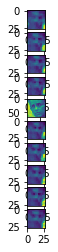

In [116]:
fig, axs = plt.subplots(10)
for i,ax in enumerate(axs):
    ax.imshow(et.entities[0].frames[i]) 

Faces tracked: Example 2

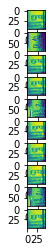

In [119]:
fig, axs = plt.subplots(10)
for i,ax in enumerate(axs):
    ax.imshow(et.entities[2].frames[i]) 

Faces tracked: Example 3

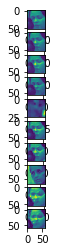

In [120]:
fig, axs = plt.subplots(10)
for i,ax in enumerate(axs):
    ax.imshow(et.entities[3].frames[i]) 

Faces tracked: Example 4

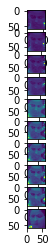

In [121]:
fig, axs = plt.subplots(10)
for i,ax in enumerate(axs):
    ax.imshow(et.entities[4].frames[i]) 

Faces tracked: Example 5

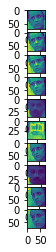

In [122]:
fig, axs = plt.subplots(10)
for i,ax in enumerate(axs):
    ax.imshow(et.entities[5].frames[i]) 

Faces tracked: Example 6

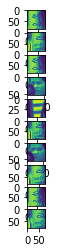

In [123]:
fig, axs = plt.subplots(10)
for i,ax in enumerate(axs):
    ax.imshow(et.entities[6].frames[i]) 

Faces tracked: Example 7

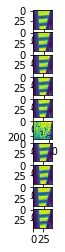

In [124]:
fig, axs = plt.subplots(10)
for i,ax in enumerate(axs):
    ax.imshow(et.entities[7].frames[i]) 

Faces tracked: Example 8

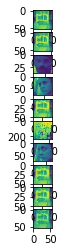

In [125]:
fig, axs = plt.subplots(10)
for i,ax in enumerate(axs):
    ax.imshow(et.entities[8].frames[i]) 

Faces tracked: Example 9

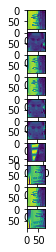

In [126]:
fig, axs = plt.subplots(10)
for i,ax in enumerate(axs):
    ax.imshow(et.entities[9].frames[i]) 

You can run this code, to see the this very basic face detection model performs

In [ ]:
import numpy as np
import cv2

face_cascade = cv2.CascadeClassifier('D:/opencv-master/opencv-master/data/haarcascades/haarcascade_frontalface_alt.xml')
cap = cv2.VideoCapture('Downloads/Pexels Videos 2851.mp4')

while(cap.isOpened()):
    ret, frame = cap.read() 
        
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
    bodies = face_cascade.detectMultiScale(cv2.cvtColor(frame,cv2.COLOR_RGB2GRAY))
        
    for (x,y,w,h) in bodies:
        cv2.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),3)

    cv2.imshow('frame',gray)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
# Take first frame and identify the entities in it
cap = cv.VideoCapture('Pexels Videos 2851.mp4')
ret, old_frame = cap.read()  

In [ ]:
face_cascade = cv.CascadeClassifier('opencv/data/haarcascades/haarcascade_frontalface_alt.xml')
face_cascade.detectMultiScale(gray(old_frame))

In [ ]:
# find the objects
objects = entities(old_frame)

In [ ]:
temp = []

In [ ]:
for ob in objects: 
    x = getPk(ob,old_frame)
    if x is not None:
        temp.append(x)           
    object_reps = np.vstack(temp)

In [ ]:
object_reps

In [ ]:
#while(cap.isOpened()):
ret, new_frame = cap.read() 
updated_reps, st, err = updatedFeature(old_frame,new_frame,object_reps)

In [ ]:
updated_reps

In [ ]:
# find the objects
objects_2 = entities(new_frame)

In [ ]:
temp = []
for ob in objects_2: 
    x = getPk(ob,old_frame)
    if x is not None:
        temp.append(x)           
    object_reps_2 = np.vstack(temp)

In [ ]:
object_reps_2

In [ ]:
# case where the new set objects, are

In [ ]:
array([[1319,  665,   26,   26],
       [ 303,  530,   39,   39],
       [1622,  411,   45,   45],
       [1368,  698,   52,   52],
       [1427,  766,   58,   58],
       [1244,  719,   70,   70],
       [1514,  339,   87,   87]],